In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler
)
import warnings
warnings.filterwarnings("ignore")
import time as time

#from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
#from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Questions for data exploration:

1. Which factors contribute most to the number of bicycles being checked
out over the course of a given day?

2. How much of an impact does weather have on demand?

3. How does the behavior of casual users differ from subscribers?

## Data Fields

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

## Goal of the weekly task ###
##### - tips: for the level of polynomial, count peak in monthly count for two years then +1
##### - tips: create also 24 hour group counts so we understand how many peaks there are
##### - tips: np.log1p('count"), for issemetric data apply log transformation for better fitting

#### Read the data ### 

In [3]:
data = pd.read_csv("/Users/wukaiti/Spiced/weekly_milstones/week_03/bike-sharing-demand/train.csv")


In [4]:
kaggle_test = pd.read_csv("/Users/wukaiti/Spiced/weekly_milstones/week_03/bike-sharing-demand/test.csv")

In [5]:
nextsaturday = pd.DataFrame({
    "datetime": [pd.to_datetime("20230415-14:00:00")],
    "season": [1],
    "holiday": [0],
    "workingday": [0],
    "weather": [3],
    "temp": [23.3],
    "atemp": [24],
    "humidity": [76],
    "windspeed": [5]
}).set_index("datetime")

In [ ]:
#RMSLE = root mean squared logarithmic Error

In [6]:
data["datetime"] = pd.to_datetime(data["datetime"])

In [7]:
data["hour"] = data["datetime"].dt.hour
data["months"] = data["datetime"].dt.month
data["years"] = data["datetime"].dt.year
data["dayofweek"] = data["datetime"].dt.dayofweek

In [8]:
kaggle_test["datetime"] =  pd.to_datetime(kaggle_test["datetime"])
kaggle_test['year'] = kaggle_test.index.year
kaggle_test['month'] = kaggle_test.index.month
kaggle_test['day'] = kaggle_test.index.day
kaggle_test['hour'] = kaggle_test.index.hour


nextsaturday['year'] = nextsaturday.index.year
nextsaturday['month'] = nextsaturday.index.month
nextsaturday['day'] = nextsaturday.index.day
nextsaturday['hour'] = nextsaturday.index.hour

In [ ]:
# Command Key Command id
## Select all occurrences of current selection	
## editor.action.selectHighlights

### Train test split ###

#### EDA

### Registered trend

(1.0, 12.0)

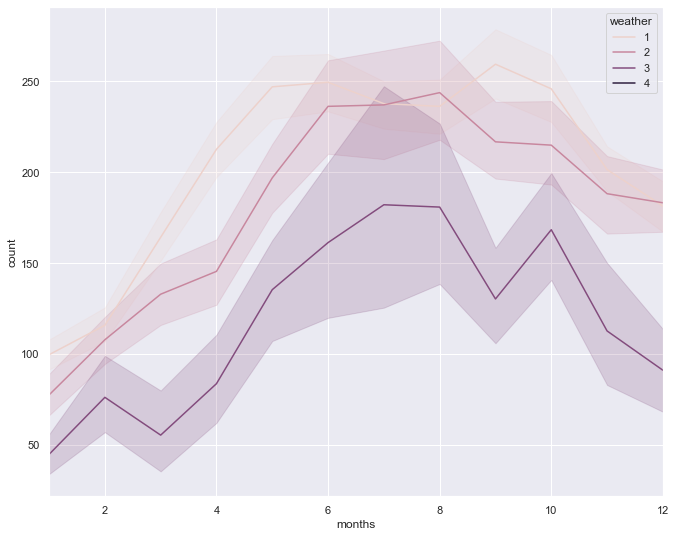

In [394]:
sns.set(rc={"figure.figsize":(11,9)})
sns.color_palette("Set1")
sns.lineplot(x="months",y="count",data=data, hue="weather",estimator=np.average)
plt.xlim(1,12)

### Split feature datatype

In [10]:
train, test = train_test_split(data, test_size=0.2, random_state=42)
train.shape, test.shape

num_features = [
    "atemp"
]

cat_features = [
    "season",
    "holiday",
    "workingday",
    "weather",
    "hour",
    "month",
]

features = num_features + cat_features

# Prepare data for prediction of target "registered"
X_train_r = train.drop(["count", "registered", "casual"], axis=1)
y_train_r = np.log1p(train["registered"])

X_test_r = test.drop(["count", "registered", "casual"], axis=1)
y_test_r = np.log1p(test["registered"])


# Prepare data for prediction of target "casual"
X_train_c = train.drop(["count", "registered", "casual"], axis=1)
y_train_c = np.log1p(train["casual"])

X_test_c = test.drop(["count", "registered", "casual"], axis=1)
y_test_c = np.log1p(test["casual"])



In [11]:
numerical_features = [
    "atemp",
]

categorical_features = [
    "weather",
    "workingday",
    "months",
    "dayofweek"
]

features = numerical_features + categorical_features

target_variable = "count"

### Feature engineering: create feature and target columns (baseline model)

In [12]:
X,y = data[features],data[target_variable]

### Baseline model

In [16]:
class BaselineModel:
    def predict(self, X):
        y_mean = y_train_r .mean()
        return [y_mean]*X.shape[0]

from sklearn.metrics import r2_score
y_baseline_train_pred = BaselineModel().predict(X_train_r)
r2 = r2_score(y_train_r,y_baseline_train_pred)

print(f"basline model train score: {round(r2,6)}")

y_baseline_test_pred = BaselineModel().predict(X_test_r)
r2_1 = r2_score(y_test_r ,y_baseline_test_pred)
print(f"basline model test score: {round(r2_1,6)}")

basline model train score: 0.0
basline model test score: -5.8e-05


### Feature engineering: create feature and target columns (test model)

In [17]:
# column transformation
col_transformer = ColumnTransformer([ 
    ("scaling", MinMaxScaler(),numerical_features),
    ("onehot", OneHotEncoder(drop="first"),categorical_features)
])

In [18]:
pipeline = Pipeline(
    [("col_transformer",col_transformer),
    ("lr_model",LogisticRegression(fit_intercept=True))]
)

### Model training

In [19]:
# method to reduce negative count predictions
ytrainlog = np.log1p(y_train_r + 1)
ytestlog = np.log1p(y_test_r + 1) # log 1 plus its there already

In [ ]:
# https://stackoverflow.com/questions/65418378/valueerror-a-given-column-is-not-a-column-of-the-dataframe
## fixed error : "ValueError: A given column is not a column of the dataframe"
pipeline.fit(X_train_r,y_train_r)

In [ ]:
result = pipeline.predict(X_test1)

### Hyperparameter Optimization step

In [21]:
pol_featuress1 = [
    "months",
    "hour"
]

numerical_features1 = [
    "atemp"
]

categorical_features1 = [
    "holiday",
    "workingday"
]

features1 = numerical_features1 + categorical_features1
target_variable1 = "count"

X1, y1 = data[features1],data[target_variable1]
X_train1,X_test1,y_train1,y_test1 = train_test_split(X1,y1,test_size=0.2, random_state=42)
X_train1.shape, X_test1.shape

((8708, 3), (2178, 3))

In [22]:
#scaling / polynomial features

numerical_transformer1 = Pipeline(
    steps = [
        ("scaler", StandardScaler()), 
        ("polynomial", PolynomialFeatures())
    ]
)

categorical_transformer1 = Pipeline(
    steps = [
        ("ohe", OneHotEncoder(drop="first"))
    ]
)

preprocess1 = ColumnTransformer( 
    transformers=[
        ("num",numerical_transformer1, numerical_features1),
        ("cat", categorical_transformer1, categorical_features1)
    ]
)

In [23]:
estimator1 = Pipeline(
    steps = [
        ("preprocess1", preprocess1), 
        ("lassoo",Lasso())
    ]
)

In [24]:
param_grid1 = {
    "preprocess1__num__polynomial__degree": [2,3], 
    "preprocess1__num__polynomial__interaction_only": [False,True],
    "lassoo__alpha": [100.,10.,1.,0.1,0.01], 
    #"lassoo_max_iter": [5000, 10000, 20000]
}

In [25]:
#Gridsearch
gscv = GridSearchCV(
    estimator=estimator1, 
    param_grid = param_grid1, 
    scoring = "neg_root_mean_squared_error", 
    cv = 5, 
    n_jobs = -1,
    verbose = 1
)

In [42]:
ti = time.time()

gscv.fit(X_train_r,y_train_r)

tf = time.time()

print(f"time taken: {round(tf - ti,2)} sec")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
time taken: 0.18 sec


In [43]:
gscv

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess1',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('polynomial',
                                                                                          PolynomialFeatures())]),
                                                                         ['atemp']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                  

In [44]:
column_list = [ 
    "param_preprocess1__num__polynomial__degree",
    "param_preprocess1__num__polynomial__interaction_only", 
    "param_lassoo__alpha", 
    #"param_lassoo__max_iter", 
    "mean_test_score", 
    "rank_test_score"
]

result_df = pd.DataFrame(gscv.cv_results_)[column_list]

result_df.rename(
    columns=lambda name: name.split("__")[-1],inplace = True
)

result_df.sort_values(
    by="rank_test_score",ascending = True, inplace = True, ignore_index = True
)

result_df.head()

,degree,interaction_only,alpha,mean_test_score,rank_test_score
0,3,False,0.01,-1.320840,1
1,3,True,0.01,-1.322488,2
2,2,True,0.01,-1.322488,2
3,2,False,0.01,-1.322649,4
4,3,True,0.1,-1.326658,5


In [58]:
result_df

,degree,interaction_only,alpha,mean_test_score,rank_test_score
0,3,False,0.01,-1.320840,1
1,3,True,0.01,-1.322488,2
2,2,True,0.01,-1.322488,2
3,2,False,0.01,-1.322649,4
4,3,True,0.1,-1.326658,5
5,2,True,0.1,-1.326658,5
6,2,False,0.1,-1.326658,5
7,3,False,0.1,-1.327714,8
8,3,False,1.0,-1.389780,9
9,3,True,1.0,-1.396098,10


In [45]:
best_model = gscv.best_estimator_
best_model

Pipeline(steps=[('preprocess1',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures(degree=3))]),
                                                  ['atemp']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['holiday', 'workingday'])])),
                ('lassoo', Lasso(alpha=0.01))])

In [46]:
training_score = pipeline.score(X_train_r,y_train_r)
print(f"training score: {round(training_score,3)}")

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [49]:
test_score = pipeline.score(X_test_r,y_test_r)
print(f"test score:{round(test_score,3)}")

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

### Model building with Polypipeline

In [50]:
from sklearn.pipeline import make_pipeline

pipelinepol = make_pipeline(
    PolynomialFeatures(degree=6),
    LinearRegression()
)

In [51]:
pipelinepol.fit(X_train1,y_train1)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=6)),
                ('linearregression', LinearRegression())])

In [52]:
pipelinepol.score(X_train1,y_train1)

0.16219158815914347

In [53]:
kaggle_test.columns
test_for_kaggle = kaggle_test[["workingday","weather","atemp"]]

In [54]:
pipelinepol.predict(test_for_kaggle)

array([16810577.88270758, 49521404.246363  , 49521404.246363  , ...,
       35310229.868613  , 49521404.246363  , 49521404.246363  ])